In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import csv
import json
from matplotlib import ticker

# Flat Provider

## Responsiveness

In [2]:
projectPath = os.path.abspath(os.path.join(os.getcwd(), '..'))
mode_dir = os.path.join(projectPath, 'sumoenv/scenarios/normal_flat/social_groups')

records = []
# Traverse each folder inside the mode
for date in os.listdir(mode_dir):
    date_path = os.path.join(mode_dir, date)
    if not os.path.isdir(date_path):
        continue
    summary_path = os.path.join(date_path, 'simulation_summary.csv')
    if os.path.exists(summary_path):
        df = pd.read_csv(summary_path)
        if not df.empty:
            # Get time metrics
            first_row = df.iloc[0]
            elapsed_sec = first_row['total_elapsed_seconds']
            sumo_sec = first_row['sumo_time']
            agents_sec = first_row['agents_time']
            metrics_path = os.path.join(date_path, 'sf_final_metrics.csv')
            if os.path.exists(metrics_path):
                df_metrics = pd.read_csv(metrics_path)
                if not df_metrics.empty:
                    records.append({
                        'mode': 'social_groups',
                        'date': date,
                        'elapsed_seconds': elapsed_sec,
                        'elapsed_minutes': round(elapsed_sec / 60, 2),
                        'sumo_time': sumo_sec,
                        'sumo_minutes': round(sumo_sec / 60, 2),
                        'agents_time': agents_sec,
                        'agents_minutes': round(agents_sec / 60, 2),
                        'sumo_perc_time': round(sumo_sec / elapsed_sec, 2),
                        'agents_perc_time': round(agents_sec / elapsed_sec, 2) if agents_sec > 0 else 0
                    })

summary_df = pd.DataFrame(records)
output_file = os.path.join(projectPath, 'experiments/results/responsiveness_normal_flat.csv')
summary_df = summary_df.sort_values(by=['date'])
summary_df.to_csv(output_file, index=False)
print(f"Responsiveness summary saved to: {output_file}")

Responsiveness summary saved to: /Users/beyzaeken/Desktop/sfdigitalmirror/experiments/results/responsiveness_normal_flat.csv


## Fidelity

In [3]:
def get_pickups_dropoffs(
        sf_rides_stats_path,
        start_date_str,
        start_time_str,
        end_date_str,
        end_time_str,
        tazs_involved=None
    ):
    start_date = datetime.strptime(start_date_str, "%y%m%d").date()
    end_date = datetime.strptime(end_date_str, "%y%m%d").date()
    num_days = (end_date - start_date).days + 1
    start_hour = int(datetime.strptime(start_time_str, "%H").hour)
    end_hour = int(datetime.strptime(end_time_str, "%H").hour)

    # Map dataset hours (3–26) to standard 0–23 format
    dataset_hour_map = {h: h % 24 for h in range(3, 27)}

    all_rows = []
    with open(sf_rides_stats_path, mode='r') as file:
        reader = csv.DictReader(file, delimiter=',')
        for row in reader:
            row['taz'] = int(row['taz'])
            row['day_of_week'] = int(row['day_of_week'])
            row['hour'] = int(row['hour'])
            row['pickups'] = round(float(row['pickups']))
            row['dropoffs'] = round(float(row['dropoffs']))
            all_rows.append(row)

    # Index by (day_of_week, hour, taz)
    data_by_key = {}
    for row in all_rows:
        key = (row['day_of_week'], row['hour'], row['taz'])
        data_by_key[key] = {'pickups': row['pickups'], 'dropoffs': row['dropoffs']}

    zone_data = {}
    # For each simulation day, determine hours to include from that day
    for sim_day_index in range(num_days):
        sim_date = start_date + timedelta(days=sim_day_index)
        sim_day_of_week = sim_date.weekday()
        if num_days == 1:
            selected_std_hours = list(range(start_hour, end_hour))
        else:
            if sim_day_index == 0:
                selected_std_hours = list(range(start_hour, 24))
            elif sim_day_index == num_days - 1:
                selected_std_hours = list(range(0, end_hour))
            else:
                selected_std_hours = list(range(0, 24))
        selected_dataset_hours = {h: std for h, std in dataset_hour_map.items() if std in selected_std_hours}
        # Filter rows for this day and hour
        for row in all_rows:
            taz = row['taz']
            hour = row['hour']
            day = row['day_of_week']
            if day == sim_day_of_week and hour in selected_dataset_hours:
                std_hour = selected_dataset_hours[hour]
                if taz not in zone_data:
                    zone_data[taz] = {}
                zone_data[taz][std_hour] = {
                    'pickups': row['pickups'],
                    'dropoffs': row['dropoffs']
                }
    
    # If tazs_involved is provided, adjust pickups and dropoffs based on "underground" disruptive scenario
    if tazs_involved:
        for taz in zone_data:
            if taz in tazs_involved:
                for hour in zone_data[taz]:
                    if hour == 23 or hour == 11:
                        zone_data[taz][hour]['pickups'] += round((zone_data[taz][hour]['pickups'] * 2) * 0.67)
                        zone_data[taz][hour]['dropoffs'] += round((zone_data[taz][hour]['dropoffs'] * 2) * 0.67)

    # Compute pickups and dropoffs across all zones and selected hours
    total_pickups = sum(hour_data['pickups'] for zone in zone_data.values() for hour_data in zone.values())
    total_dropoffs = sum(hour_data['dropoffs'] for zone in zone_data.values() for hour_data in zone.values())

    return total_pickups, total_dropoffs


def percent_error(true_val, estimated_val):
    return 100 * abs(true_val - estimated_val) / true_val if true_val != 0 else float('nan')

In [ ]:
projectPath = os.path.abspath(os.path.join(os.getcwd(), '..'))
mode_dir = os.path.join(projectPath, 'sumoenv/scenarios/normal_flat/social_groups')
traffic_dir = os.path.join(projectPath, 'data/sf_traffic/sfmta_dataset')
sfcta_dir = os.path.join(projectPath, 'data/ridehailing_stats')

def compute_geh(observed, modeled):
    return np.sqrt(2 * (observed - modeled)**2 / (observed + modeled + 1e-6))

records = []
# Traverse each folder inside the mode
for date in os.listdir(mode_dir):
    start, end = date.split('_')
    start_date_str = "20" + start[:6]
    start_time_str = start[6:] + "00"
    end_date_str = "20" + end[:6]
    end_time_str = end[6:] + "00"
    date_path = os.path.join(mode_dir, date)
    if not os.path.isdir(date_path):
        continue
    summary_path = os.path.join(date_path, 'sf_final_metrics.csv')
    # Get real traffic data
    traffic_file = [f for f in os.listdir(traffic_dir) if os.path.isfile(os.path.join(traffic_dir, f)) and date in f]
    traffic_df = pd.read_csv(os.path.join(traffic_dir, traffic_file[0]))
    traffic_df["vehicle_position_date_time"] = pd.to_datetime(traffic_df["vehicle_position_date_time"])
    start_dt = datetime.strptime(f"{start_date_str} {start_time_str}", "%Y%m%d %H%M")
    end_dt = datetime.strptime(f"{end_date_str} {end_time_str}", "%Y%m%d %H%M")
    traffic_df = traffic_df[(traffic_df["vehicle_position_date_time"] >= start_dt) & (traffic_df["vehicle_position_date_time"] < end_dt)]
    # Filter out vehicles that have speed == 0 for all their records
    valid_vehicle_ids = traffic_df.groupby("vehicle_id")["average_speed"].max()
    valid_vehicle_ids = valid_vehicle_ids[valid_vehicle_ids > 0].index
    traffic_df = traffic_df[traffic_df["vehicle_id"].isin(valid_vehicle_ids)]
    traffic = (len(traffic_df)-1) if traffic_file else 0
    # Scale traffic: 36% of traffic is TNC
    traffic_scaled = int(traffic * 0.64)
    start_str, end_str = date.split('_')
    # Get pickups and dropoffs data
    pickups, dropoffs = get_pickups_dropoffs(
        os.path.join(sfcta_dir, "trip_stats_taz.csv"),
        start_str[:6],
        start_str[6:],
        end_str[:6],
        end_str[6:]
    )
    # Compute errors and record results
    if os.path.exists(summary_path):
        df = pd.read_csv(summary_path)
        if not df.empty:
            traffic_count = sum(df['traffic_departures'])
            pickup_count = sum(df['passengers_departures'])
            dropoff_count = sum(df['passengers_arrivals'])
            canceled_count = sum(df['passengers_cancel']) + sum(df['rides_not_served'])
            traffic_error = percent_error(traffic_scaled, traffic_count)
            pickup_error = percent_error(pickups, pickup_count)
            dropoff_error = percent_error(dropoffs, dropoff_count)
            pickup_scaled_error = percent_error(pickups, pickup_count + canceled_count)
            dropoff_scaled_error = percent_error(dropoffs, dropoff_count + canceled_count)
            # Compute GEH hourly values
            if end_time_str in ["0900", "2100"]:
                geh_traffic = compute_geh(traffic_scaled, traffic_count)
                geh_pickup = compute_geh(pickups, pickup_count + canceled_count)
                geh_dropoff = compute_geh(dropoffs, dropoff_count + canceled_count)
            if end_time_str in ["1100", "2300"]:
                geh_traffic = compute_geh(traffic_scaled/3, traffic_count/3)
                geh_pickup = compute_geh(pickups/3, (pickup_count + canceled_count)/3)
                geh_dropoff = compute_geh(dropoffs/3, (dropoff_count + canceled_count)/3)
            if end_time_str in ["1400", "0200"]:
                geh_traffic = compute_geh(traffic_scaled/6, traffic_count/6)
                geh_pickup = compute_geh(pickups/6, (pickup_count + canceled_count)/6)
                geh_dropoff = compute_geh(dropoffs/6, (dropoff_count + canceled_count)/6)
            if end_time_str in ["2000", "0800"]:
                geh_traffic = compute_geh(traffic_scaled/12, traffic_count/12)
                geh_pickup = compute_geh(pickups/12, (pickup_count + canceled_count)/12)
                geh_dropoff = compute_geh(dropoffs/12, (dropoff_count + canceled_count)/12)
            records.append({
                'mode': 'social_groups',
                'date': date,
                'traffic_input': traffic_scaled,
                'pickup_input': pickups,
                'dropoff_input': dropoffs,
                'traffic_output': traffic_count,
                'pickup_output': pickup_count,
                'dropoff_output': dropoff_count,
                'traffic_error': round(traffic_error, 2),
                'pickup_error': round(pickup_error, 2),
                'dropoff_error': round(dropoff_error, 2),
                'canceled_rides': canceled_count,
                'pickup_scaled_error': round(pickup_scaled_error, 2),
                'dropoff_scaled_error': round(dropoff_scaled_error, 2),
                'geh_traffic': round(geh_traffic, 2),
                'geh_pickup': round(geh_pickup, 2),
                'geh_dropoff': round(geh_dropoff, 2)
            })

# Save results to CSV
summary_df = pd.DataFrame(records)
output_file = os.path.join(projectPath, 'experiments/results/fidelity_normal_flat.csv')
summary_df = summary_df.sort_values(by=['date'])
summary_df.to_csv(output_file, index=False)

print(f"Fidelity summary saved to: {output_file}")

Fidelity summary saved to: /Users/beyzaeken/Desktop/sfdigitalmirror/experiments/results/fidelity_normal_flat.csv


# Underground Alarm

## Analyze Metrics

In [5]:
projectPath = os.path.abspath(os.path.join(os.getcwd(), '..'))

underground_data_path = os.path.join(projectPath, 'sumoenv/scenarios/underground_alarm/social_groups')
subfolders = [os.path.join(underground_data_path, d) for d in os.listdir(underground_data_path)
              if os.path.isdir(os.path.join(underground_data_path, d))]
df_under_list = []
date_list = []
for folder in subfolders:
    file_path = os.path.join(folder, "sf_final_metrics.csv")
    df = pd.read_csv(file_path)
    date_list.append(folder.split('/')[-1])
    df_under_list.append(df)
# Concatenate all underground data into a single DataFrame and compute average metrics
df_under_avg = pd.concat(df_under_list).groupby(level=0).mean()

normal_data_path = os.path.join(projectPath, 'sumoenv/scenarios/normal')
social_group_folders = ['social_groups_1', 'social_groups_2', 'social_groups_3']
df_normal_list = []
# Iterate through each social group folder
for group_folder in social_group_folders:
    group_path = os.path.join(normal_data_path, group_folder)
    for date in date_list:
        date_folder_path = os.path.join(group_path, str(date))
        csv_path = os.path.join(date_folder_path, 'sf_final_metrics.csv')
        if os.path.isfile(csv_path):
            df = pd.read_csv(csv_path)
            df_normal_list.append(df)
# Concatenate all normal data into a single DataFrame and compute average metrics
df_normal_avg = pd.concat(df_normal_list).groupby(level=0).mean()

# Surge multiplier columns that shouldn't be smoothed but padded
surge_columns = [
    "rides_offers_surge_avg",
    "rides_offers_surge_lyft_avg",
    "rides_offers_surge_uber_avg"
]
# Agents columns that should be padded with forward-fill every 60 seconds before smoothing
agent_columns = [
    "passengers_unassigned",
    "passengers_assigned",
    "passengers_accept",
    "passengers_reject",
    "passengers_cancel",
    "drivers_idle",
    "drivers_pickup",
    "drivers_busy",
    "drivers_accept",
    "drivers_reject",
    "drivers_removed",
    "rides_duration_expected_avg",
    "rides_length_expected_avg",
    "rides_offers_radius_avg",
    "rides_offers_price_avg",
    "rides_dispatched",
    "rides_in_progress",
    "rides_offers_generated",
    "rides_partial_acceptances"
]

# Process the surge_columns: pad with forward-fill
for col in surge_columns:
    df_under_avg[col] = df_under_avg[col].replace(0, np.nan)
    df_under_avg[col] = df_under_avg[col].fillna(method='ffill')
# Process the agent_columns: pad with forward-fill
for col in agent_columns:
    for i in range(0, len(df_under_avg), 60):
        val = df_under_avg.at[i, col]
        df_under_avg.loc[i:i+59, col] = val
# Apply rolling mean to all other columns
rolling_cols = [col for col in df_under_avg.columns if col not in surge_columns + ["timestamp"]]
for col in rolling_cols:
    df_under_avg[col] = df_under_avg[col].rolling(window=300).mean().dropna()

# Process the surge_columns: pad with forward-fill
for col in surge_columns:
    df_normal_avg[col] = df_normal_avg[col].replace(0, np.nan)
    df_normal_avg[col] = df_normal_avg[col].fillna(method='ffill')
# Process the agent_columns: pad with forward-fill
for col in agent_columns:
    for i in range(0, len(df_normal_avg), 60):
        val = df_normal_avg.at[i, col]
        df_normal_avg.loc[i:i+59, col] = val
# Apply rolling mean to all other columns
rolling_cols = [col for col in df_normal_avg.columns if col not in surge_columns + ["timestamp"]]
for col in rolling_cols:
    df_normal_avg[col] = df_normal_avg[col].rolling(window=300).mean().dropna()

df_normal_avg = df_normal_avg[5400:-3600]
df_under_avg = df_under_avg[5400:-3600]

# Plot each column (excluding timestamp)
'''
for column in df_under_avg.columns:
    if column == "timestamp":
        continue
    plt.figure()
    plt.plot(df_under_avg["timestamp"], df_under_avg[column], label=column)
    plt.title(f"Processed: {column}")
    plt.xlabel("Timestamp")
    plt.ylabel(column)
    plt.legend()
    plt.grid(True)
    plt.show()
'''


/var/folders/03/ywz8jzld3gs1b0zsd9kydy940000gq/T/ipykernel_16077/465215990.py:63: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_under_avg[col] = df_under_avg[col].fillna(method='ffill')
/var/folders/03/ywz8jzld3gs1b0zsd9kydy940000gq/T/ipykernel_16077/465215990.py:77: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_normal_avg[col] = df_normal_avg[col].fillna(method='ffill')


'\nfor column in df_under_avg.columns:\n    if column == "timestamp":\n        continue\n    plt.figure()\n    plt.plot(df_under_avg["timestamp"], df_under_avg[column], label=column)\n    plt.title(f"Processed: {column}")\n    plt.xlabel("Timestamp")\n    plt.ylabel(column)\n    plt.legend()\n    plt.grid(True)\n    plt.show()\n'

## Compare Surge Multiplier

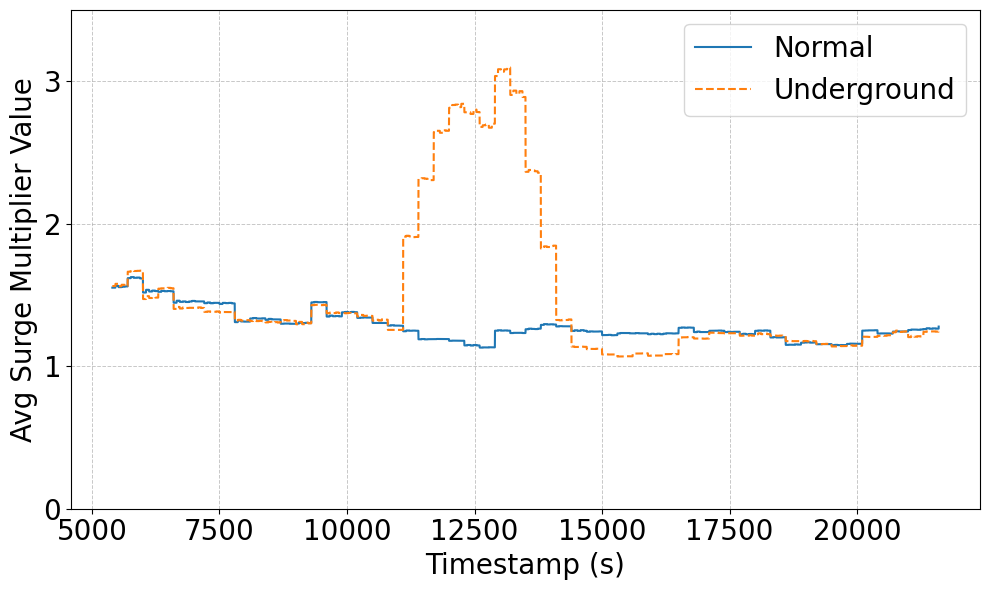

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(df_normal_avg["timestamp"], df_normal_avg["rides_offers_surge_avg"], label="Normal")
plt.plot(df_under_avg["rides_offers_surge_avg"], label="Underground", linestyle='--')
plt.xlabel("Timestamp (s)", fontsize=20)
plt.ylabel("Avg Surge Multiplier Value", fontsize=20)
plt.ylim(0, 3.5)
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=8))
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(nbins=4))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.legend(fontsize=20)
plt.grid(True)
plt.tight_layout()
plt.savefig("results/avg_surge_multiplier_comparison_underground.png", dpi=300, bbox_inches='tight')
plt.show()

## Responsiveness

In [7]:
projectPath = os.path.abspath(os.path.join(os.getcwd(), '..'))
mode_dir = os.path.join(projectPath, 'sumoenv/scenarios/underground_alarm/social_groups')

records = []
# Traverse each folder inside the mode
for date in os.listdir(mode_dir):
    date_path = os.path.join(mode_dir, date)
    if not os.path.isdir(date_path):
        continue
    summary_path = os.path.join(date_path, 'simulation_summary.csv')
    if os.path.exists(summary_path):
        df_summary = pd.read_csv(summary_path)
        if not df_summary.empty:
            # Get time metrics
            first_row = df_summary.iloc[0]
            elapsed_sec = first_row['total_elapsed_seconds']
            sumo_sec = first_row['sumo_time']
            agents_sec = first_row['agents_time']
            metrics_path = os.path.join(date_path, 'sf_final_metrics.csv')
            if os.path.exists(metrics_path):
                df_metrics = pd.read_csv(metrics_path)
                if not df_metrics.empty:
                    records.append({
                        'mode': 'social_groups',
                        'date': date,
                        'elapsed_seconds': elapsed_sec,
                        'elapsed_minutes': round(elapsed_sec / 60, 2),
                        'sumo_time': sumo_sec,
                        'sumo_minutes': round(sumo_sec / 60, 2),
                        'agents_time': agents_sec,
                        'agents_minutes': round(agents_sec / 60, 2),
                        'sumo_perc_time': round(sumo_sec / elapsed_sec, 2),
                        'agents_perc_time': round(agents_sec / elapsed_sec, 2) if agents_sec > 0 else 0
                    })

summary_df = pd.DataFrame(records)
output_file = os.path.join(projectPath, 'experiments/results/responsiveness_underground.csv')
summary_df = summary_df.sort_values(by=['date'])
summary_df.to_csv(output_file, index=False)
print(f"Responsiveness summary saved to: {output_file}")

Responsiveness summary saved to: /Users/beyzaeken/Desktop/sfdigitalmirror/experiments/results/responsiveness_underground.csv


## Fidelity

In [ ]:
projectPath = os.path.abspath(os.path.join(os.getcwd(), '..'))
mode_dir = os.path.join(projectPath, 'sumoenv/scenarios/underground_alarm/social_groups')
traffic_dir = os.path.join(projectPath, 'data/sf_traffic/sfmta_dataset')
sfcta_dir = os.path.join(projectPath, 'data/ridehailing_stats')

def compute_geh(observed, modeled):
    return np.sqrt(2 * (observed - modeled)**2 / (observed + modeled + 1e-6))

# Initialize records and TAZs involved
records = []
tazs_involved = None
with open(os.path.join(projectPath, "config/zip_zones_config.json"), "r") as f:
    zip_zones = json.load(f)
    tazs_involved = []
    with open(os.path.join(projectPath, "data/sf_zones/sf_sfcta_stanford_mapping.json"), "r") as f:
        sfcta_mapping = json.load(f)
    for taz in zip_zones["downtown"]:
        if taz in sfcta_mapping:
            tazs_involved.extend(sfcta_mapping[taz])

# Traverse each folder inside the mode
for date in os.listdir(mode_dir):
    start, end = date.split('_')
    start_date_str = "20" + start[:6]
    start_time_str = start[6:] + "00"
    end_date_str = "20" + end[:6]
    end_time_str = end[6:] + "00"
    date_path = os.path.join(mode_dir, date)
    if not os.path.isdir(date_path):
        continue
    summary_path = os.path.join(date_path, 'sf_final_metrics.csv')
    # Get real traffic data
    traffic_file = [f for f in os.listdir(traffic_dir) if os.path.isfile(os.path.join(traffic_dir, f)) and date in f]
    traffic_df = pd.read_csv(os.path.join(traffic_dir, traffic_file[0]))
    od_df = pd.read_csv(os.path.join(date_path, f"sf_traffic_od_{date}.csv"), sep=';')
    traffic_df["vehicle_position_date_time"] = pd.to_datetime(traffic_df["vehicle_position_date_time"])
    start_dt = datetime.strptime(f"{start_date_str} {start_time_str}", "%Y%m%d %H%M")
    end_dt = datetime.strptime(f"{end_date_str} {end_time_str}", "%Y%m%d %H%M")
    traffic_df = traffic_df[(traffic_df["vehicle_position_date_time"] >= start_dt) & (traffic_df["vehicle_position_date_time"] < end_dt)]
    # Filter out vehicles that have speed == 0 for all their records
    valid_vehicle_ids = traffic_df.groupby("vehicle_id")["average_speed"].max()
    valid_vehicle_ids = valid_vehicle_ids[valid_vehicle_ids > 0].index
    traffic_df = traffic_df[traffic_df["vehicle_id"].isin(valid_vehicle_ids)]
    # Filter the traffic data by hours and TAZs involved
    od_df = od_df[od_df['origin_taz_id'].isin(tazs_involved)]
    od_df_filtered_taz = od_df.copy()
    od_df_filtered_taz['origin_starting_time'] = pd.to_datetime(od_df_filtered_taz['origin_starting_time'])
    time_ranges = [
    (pd.to_datetime('11:00:00').time(), pd.to_datetime('11:40:00').time()),
    (pd.to_datetime('23:00:00').time(), pd.to_datetime('23:40:00').time())
    ]
    od_df_filtered_taz_time = od_df_filtered_taz[
        od_df_filtered_taz['origin_starting_time'].dt.time.between(*time_ranges[0]) |
        od_df_filtered_taz['origin_starting_time'].dt.time.between(*time_ranges[1])
    ]
    # Consider +50% traffic
    added_count = len(od_df_filtered_taz_time) * 0.5
    traffic = (len(traffic_df)-1) if traffic_file else 0
    # Scale traffic: 36% of traffic is TNC
    traffic_scaled = int((traffic+added_count) * 0.64)
    # Get pickups and dropoffs data
    start_str, end_str = date.split('_')
    pickups, dropoffs = get_pickups_dropoffs(
        os.path.join(sfcta_dir, "trip_stats_taz.csv"),
        start_str[:6],
        start_str[6:],
        end_str[:6],
        end_str[6:],
        tazs_involved
    )
    # Compute errors and record results
    if os.path.exists(summary_path):
        df = pd.read_csv(summary_path)
        if not df.empty:
            traffic_count = sum(df['traffic_departures'])
            pickup_count = sum(df['passengers_departures'])
            dropoff_count = sum(df['passengers_arrivals'])
            canceled_count = sum(df['passengers_cancel'])
            traffic_error = percent_error(traffic_scaled, traffic_count)
            pickup_error = percent_error(pickups, pickup_count)
            dropoff_error = percent_error(dropoffs, dropoff_count)
            pickup_scaled_error = percent_error(pickups, pickup_count + canceled_count)
            dropoff_scaled_error = percent_error(dropoffs, dropoff_count + canceled_count)
            # Compute GEH hourly values
            if end_time_str in ["0900", "2100"]:
                geh_traffic = compute_geh(traffic_scaled, traffic_count)
                geh_pickup = compute_geh(pickups, pickup_count + canceled_count)
                geh_dropoff = compute_geh(dropoffs, dropoff_count + canceled_count)
            if end_time_str in ["1100", "2300"]:
                geh_traffic = compute_geh(traffic_scaled/3, traffic_count/3)
                geh_pickup = compute_geh(pickups/3, (pickup_count + canceled_count)/3)
                geh_dropoff = compute_geh(dropoffs/3, (dropoff_count + canceled_count)/3)
            if end_time_str in ["1400", "0200"]:
                geh_traffic = compute_geh(traffic_scaled/6, traffic_count/6)
                geh_pickup = compute_geh(pickups/6, (pickup_count + canceled_count)/6)
                geh_dropoff = compute_geh(dropoffs/6, (dropoff_count + canceled_count)/6)
            if end_time_str in ["2000", "0800"]:
                geh_traffic = compute_geh(traffic_scaled/12, traffic_count/12)
                geh_pickup = compute_geh(pickups/12, (pickup_count + canceled_count)/12)
                geh_dropoff = compute_geh(dropoffs/12, (dropoff_count + canceled_count)/12)
            records.append({
                'mode': 'social_groups',
                'date': date,
                'traffic_input': traffic_scaled,
                'pickup_input': pickups,
                'dropoff_input': dropoffs,
                'traffic_output': traffic_count,
                'pickup_output': pickup_count,
                'dropoff_output': dropoff_count,
                'traffic_error': round(traffic_error, 2),
                'pickup_error': round(pickup_error, 2),
                'dropoff_error': round(dropoff_error, 2),
                'canceled_rides': canceled_count,
                'pickup_scaled_error': round(pickup_scaled_error, 2),
                'dropoff_scaled_error': round(dropoff_scaled_error, 2),
                'geh_traffic': round(geh_traffic, 2),
                'geh_pickup': round(geh_pickup, 2),
                'geh_dropoff': round(geh_dropoff, 2)
            })

summary_df = pd.DataFrame(records)
output_file = os.path.join(projectPath, 'experiments/results/fidelity_underground.csv')
summary_df = summary_df.sort_values(by=['date'])
summary_df.to_csv(output_file, index=False)
print(f"Fidelity summary saved to: {output_file}")

Fidelity summary saved to: /Users/beyzaeken/Desktop/sfdigitalmirror/experiments/results/fidelity_underground.csv


# Wildcat Strike

## Analyze Metrics

In [9]:
projectPath = os.path.abspath(os.path.join(os.getcwd(), '..'))

strike_data_path = os.path.join(projectPath, 'sumoenv/scenarios/wildcat_strike/social_groups')
subfolders = [os.path.join(strike_data_path, d) for d in os.listdir(strike_data_path)
              if os.path.isdir(os.path.join(strike_data_path, d))]
df_strike_list = []
date_list = []
for folder in subfolders:
    file_path = os.path.join(folder, "sf_final_metrics.csv")
    df = pd.read_csv(file_path)
    date_list.append(folder.split('/')[-1])
    df_strike_list.append(df)
# Concatenate all strike data into a single DataFrame and compute average metrics
df_strike_avg = pd.concat(df_strike_list).groupby(level=0).mean()

normal_data_path = os.path.join(projectPath, 'sumoenv/scenarios/normal')
social_group_folders = ['social_groups_1', 'social_groups_2', 'social_groups_3']
df_normal_list = []
# Iterate through each social group folder
for group_folder in social_group_folders:
    group_path = os.path.join(normal_data_path, group_folder)
    for date in date_list:
        date_folder_path = os.path.join(group_path, str(date))
        csv_path = os.path.join(date_folder_path, 'sf_final_metrics.csv')
        if os.path.isfile(csv_path):
            df = pd.read_csv(csv_path)
            df_normal_list.append(df)
# Concatenate all normal data into a single DataFrame and compute average metrics
df_normal_avg = pd.concat(df_normal_list).groupby(level=0).mean()

# Surge multiplier columns that shouldn't be smoothed but padded
surge_columns = [
    "rides_offers_surge_avg",
    "rides_offers_surge_lyft_avg",
    "rides_offers_surge_uber_avg"
]
# Agents columns that should be padded with forward-fill every 60 seconds before smoothing
agent_columns = [
    "passengers_unassigned",
    "passengers_assigned",
    "passengers_accept",
    "passengers_reject",
    "passengers_cancel",
    "drivers_idle",
    "drivers_pickup",
    "drivers_busy",
    "drivers_accept",
    "drivers_reject",
    "drivers_removed",
    "rides_duration_expected_avg",
    "rides_length_expected_avg",
    "rides_offers_radius_avg",
    "rides_offers_price_avg",
    "rides_dispatched",
    "rides_in_progress",
    "rides_offers_generated",
    "rides_partial_acceptances"
]

# Process the surge_columns: pad with forward-fill
for col in surge_columns:
    df_strike_avg[col] = df_strike_avg[col].replace(0, np.nan)
    df_strike_avg[col] = df_strike_avg[col].fillna(method='ffill')
# Process the agent_columns: pad with forward-fill
for col in agent_columns:
    for i in range(0, len(df_strike_avg), 60):
        val = df_strike_avg.at[i, col]
        df_strike_avg.loc[i:i+59, col] = val
# Apply rolling mean to all other columns
rolling_cols = [col for col in df_strike_avg.columns if col not in surge_columns + ["timestamp"]]
for col in rolling_cols:
    df_strike_avg[col] = df_strike_avg[col].rolling(window=300).mean().dropna()

# Process the surge_columns: pad with forward-fill
for col in surge_columns:
    df_normal_avg[col] = df_normal_avg[col].replace(0, np.nan)
    df_normal_avg[col] = df_normal_avg[col].fillna(method='ffill')
# Process the agent_columns: pad with forward-fill
for col in agent_columns:
    for i in range(0, len(df_normal_avg), 60):
        val = df_normal_avg.at[i, col]
        df_normal_avg.loc[i:i+59, col] = val
# Apply rolling mean to all other columns
rolling_cols = [col for col in df_normal_avg.columns if col not in surge_columns + ["timestamp"]]
for col in rolling_cols:
    df_normal_avg[col] = df_normal_avg[col].rolling(window=300).mean().dropna()

df_normal_avg = df_normal_avg[5400:-3600]
df_strike_avg = df_strike_avg[5400:-3600]

# Plot each column (excluding timestamp)
'''
for column in df_strike_avg.columns:
    if column == "timestamp":
        continue
    plt.figure()
    plt.plot(df_strike_avg["timestamp"], df_strike_avg[column], label=column)
    plt.title(f"Processed: {column}")
    plt.xlabel("Timestamp")
    plt.ylabel(column)
    plt.legend()
    plt.grid(True)
    plt.show()
'''


/var/folders/03/ywz8jzld3gs1b0zsd9kydy940000gq/T/ipykernel_16077/1086174068.py:63: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_strike_avg[col] = df_strike_avg[col].fillna(method='ffill')
/var/folders/03/ywz8jzld3gs1b0zsd9kydy940000gq/T/ipykernel_16077/1086174068.py:77: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_normal_avg[col] = df_normal_avg[col].fillna(method='ffill')


'\nfor column in df_strike_avg.columns:\n    if column == "timestamp":\n        continue\n    plt.figure()\n    plt.plot(df_strike_avg["timestamp"], df_strike_avg[column], label=column)\n    plt.title(f"Processed: {column}")\n    plt.xlabel("Timestamp")\n    plt.ylabel(column)\n    plt.legend()\n    plt.grid(True)\n    plt.show()\n'

## Compare Surge Multiplier

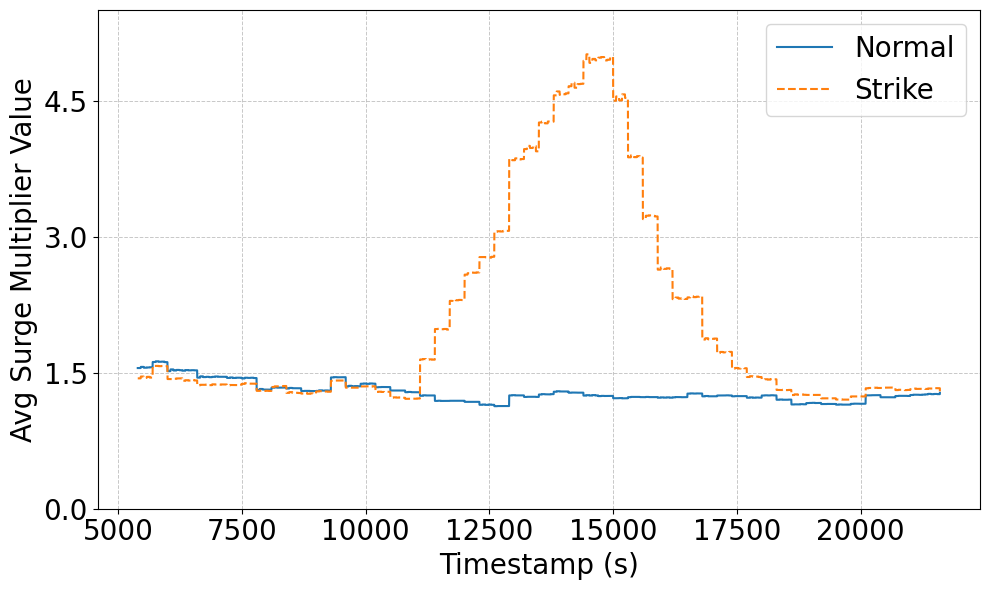

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(df_normal_avg["timestamp"], df_normal_avg["rides_offers_surge_avg"], label="Normal")
plt.plot(df_strike_avg["rides_offers_surge_avg"], label="Strike", linestyle='--')
plt.xlabel("Timestamp (s)", fontsize=20)
plt.ylabel("Avg Surge Multiplier Value", fontsize=20)
plt.ylim(0, 5.5)
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=8))
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(nbins=4))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.legend(fontsize=20)
plt.grid(True)
plt.tight_layout()
plt.savefig("results/avg_surge_multiplier_comparison_strike.png", dpi=300, bbox_inches='tight')
plt.show()

## Responsiveness

In [11]:
projectPath = os.path.abspath(os.path.join(os.getcwd(), '..'))
mode_dir = os.path.join(projectPath, 'sumoenv/scenarios/wildcat_strike/social_groups')

records = []
# Traverse each folder inside the mode
for date in os.listdir(mode_dir):
    date_path = os.path.join(mode_dir, date)
    if not os.path.isdir(date_path):
        continue
    summary_path = os.path.join(date_path, 'simulation_summary.csv')
    if os.path.exists(summary_path):
        df_summary = pd.read_csv(summary_path)
        if not df_summary.empty:
            # Get time metrics
            first_row = df_summary.iloc[0]
            elapsed_sec = first_row['total_elapsed_seconds']
            sumo_sec = first_row['sumo_time']
            agents_sec = first_row['agents_time']
            metrics_path = os.path.join(date_path, 'sf_final_metrics.csv')
            if os.path.exists(metrics_path):
                df_metrics = pd.read_csv(metrics_path)
                if not df_metrics.empty:
                    records.append({
                        'mode': 'social_groups',
                        'date': date,
                        'elapsed_seconds': elapsed_sec,
                        'elapsed_minutes': round(elapsed_sec / 60, 2),
                        'sumo_time': sumo_sec,
                        'sumo_minutes': round(sumo_sec / 60, 2),
                        'agents_time': agents_sec,
                        'agents_minutes': round(agents_sec / 60, 2),
                        'sumo_perc_time': round(sumo_sec / elapsed_sec, 2),
                        'agents_perc_time': round(agents_sec / elapsed_sec, 2) if agents_sec > 0 else 0
                    })

summary_df = pd.DataFrame(records)
output_file = os.path.join(projectPath, 'experiments/results/responsiveness_strike.csv')
summary_df = summary_df.sort_values(by=['date'])
summary_df.to_csv(output_file, index=False)
print(f"Responsiveness summary saved to: {output_file}")

Responsiveness summary saved to: /Users/beyzaeken/Desktop/sfdigitalmirror/experiments/results/responsiveness_strike.csv


## Fidelity

In [ ]:
projectPath = os.path.abspath(os.path.join(os.getcwd(), '..'))
mode_dir = os.path.join(projectPath, 'sumoenv/scenarios/wildcat_strike/social_groups')
traffic_dir = os.path.join(projectPath, 'data/sf_traffic/sfmta_dataset')
sfcta_dir = os.path.join(projectPath, 'data/ridehailing_stats')

def compute_geh(observed, modeled):
    return np.sqrt(2 * (observed - modeled)**2 / (observed + modeled + 1e-6))

records = []
# Traverse each folder inside the mode
for date in os.listdir(mode_dir):
    start, end = date.split('_')
    start_date_str = "20" + start[:6]
    start_time_str = start[6:] + "00"
    end_date_str = "20" + end[:6]
    end_time_str = end[6:] + "00"
    date_path = os.path.join(mode_dir, date)
    if not os.path.isdir(date_path):
        continue
    summary_path = os.path.join(date_path, 'sf_final_metrics.csv')
    # Get real traffic data
    traffic_file = [f for f in os.listdir(traffic_dir) if os.path.isfile(os.path.join(traffic_dir, f)) and date in f]
    traffic_df = pd.read_csv(os.path.join(traffic_dir, traffic_file[0]))
    traffic_df["vehicle_position_date_time"] = pd.to_datetime(traffic_df["vehicle_position_date_time"])
    start_dt = datetime.strptime(f"{start_date_str} {start_time_str}", "%Y%m%d %H%M")
    end_dt = datetime.strptime(f"{end_date_str} {end_time_str}", "%Y%m%d %H%M")
    traffic_df = traffic_df[(traffic_df["vehicle_position_date_time"] >= start_dt) & (traffic_df["vehicle_position_date_time"] < end_dt)]
    # Filter out vehicles that have speed == 0 for all their records
    valid_vehicle_ids = traffic_df.groupby("vehicle_id")["average_speed"].max()
    valid_vehicle_ids = valid_vehicle_ids[valid_vehicle_ids > 0].index
    traffic_df = traffic_df[traffic_df["vehicle_id"].isin(valid_vehicle_ids)]
    traffic = (len(traffic_df)-1) if traffic_file else 0
    # Scale traffic: 36% of traffic is TNC
    traffic_scaled = int(traffic * 0.64)
    # Get pickups and dropoffs data
    start_str, end_str = date.split('_')
    pickups, dropoffs = get_pickups_dropoffs(
        os.path.join(sfcta_dir, "trip_stats_taz.csv"),
        start_str[:6],
        start_str[6:],
        end_str[:6],
        end_str[6:]
    )
    # Compute errors and record results
    if os.path.exists(summary_path):
        df = pd.read_csv(summary_path)
        if not df.empty:
            traffic_count = sum(df['traffic_departures'])
            pickup_count = sum(df['passengers_departures'])
            dropoff_count = sum(df['passengers_arrivals'])
            canceled_count = sum(df['passengers_cancel'])
            traffic_error = percent_error(traffic_scaled, traffic_count)
            pickup_error = percent_error(pickups, pickup_count)
            dropoff_error = percent_error(dropoffs, dropoff_count)
            pickup_scaled_error = percent_error(pickups, pickup_count + canceled_count)
            dropoff_scaled_error = percent_error(dropoffs, dropoff_count + canceled_count)
            # Compute GEH hourly values
            if end_time_str in ["0900", "2100"]:
                geh_traffic = compute_geh(traffic_scaled, traffic_count)
                geh_pickup = compute_geh(pickups, pickup_count + canceled_count)
                geh_dropoff = compute_geh(dropoffs, dropoff_count + canceled_count)
            if end_time_str in ["1100", "2300"]:
                geh_traffic = compute_geh(traffic_scaled/3, traffic_count/3)
                geh_pickup = compute_geh(pickups/3, (pickup_count + canceled_count)/3)
                geh_dropoff = compute_geh(dropoffs/3, (dropoff_count + canceled_count)/3)
            if end_time_str in ["1400", "0200"]:
                geh_traffic = compute_geh(traffic_scaled/6, traffic_count/6)
                geh_pickup = compute_geh(pickups/6, (pickup_count + canceled_count)/6)
                geh_dropoff = compute_geh(dropoffs/6, (dropoff_count + canceled_count)/6)
            if end_time_str in ["2000", "0800"]:
                geh_traffic = compute_geh(traffic_scaled/12, traffic_count/12)
                geh_pickup = compute_geh(pickups/12, (pickup_count + canceled_count)/12)
                geh_dropoff = compute_geh(dropoffs/12, (dropoff_count + canceled_count)/12)
            records.append({
                'mode': 'social_groups',
                'date': date,
                'traffic_input': traffic_scaled,
                'pickup_input': pickups,
                'dropoff_input': dropoffs,
                'traffic_output': traffic_count,
                'pickup_output': pickup_count,
                'dropoff_output': dropoff_count,
                'traffic_error': round(traffic_error, 2),
                'pickup_error': round(pickup_error, 2),
                'dropoff_error': round(dropoff_error, 2),
                'canceled_rides': canceled_count,
                'pickup_scaled_error': round(pickup_scaled_error, 2),
                'dropoff_scaled_error': round(dropoff_scaled_error, 2),
                'geh_traffic': round(geh_traffic, 2),
                'geh_pickup': round(geh_pickup, 2),
                'geh_dropoff': round(geh_dropoff, 2)
            })

summary_df = pd.DataFrame(records)
output_file = os.path.join(projectPath, 'experiments/results/fidelity_strike.csv')
summary_df = summary_df.sort_values(by=['date'])
summary_df.to_csv(output_file, index=False)

print(f"Fidelity summary saved to: {output_file}")

Fidelity summary saved to: /Users/beyzaeken/Desktop/sfdigitalmirror/experiments/results/fidelity_strike.csv


# Compare with Normal

## Responsiveness

In [13]:
# Compare responsiveness of flat provider + disruptive scenarios with standard config
df_normal_responsiveness = pd.read_csv(os.path.join(projectPath, 'experiments/results/responsiveness_normal.csv'))
df_normal_responsiveness = df_normal_responsiveness[df_normal_responsiveness['mode'] == 'social_groups_avg']
df_flat_responsiveness = pd.read_csv(os.path.join(projectPath, 'experiments/results/responsiveness_normal_flat.csv'))
avg_normal = df_normal_responsiveness['elapsed_seconds'].mean()
avg_flat = df_flat_responsiveness['elapsed_seconds'].mean()
min_normal = df_normal_responsiveness['elapsed_seconds'].min()
min_flat = df_flat_responsiveness['elapsed_seconds'].min()
max_normal = df_normal_responsiveness['elapsed_seconds'].max()
max_flat = df_flat_responsiveness['elapsed_seconds'].max()
ratio = ((avg_flat - avg_normal) / avg_normal) * 100
print(f"Normal responsiveness min: {min_normal:.2f} seconds, max: {max_normal:.2f} seconds, average: {avg_normal:.2f} seconds")
print(f"Flat responsiveness min: {min_flat:.2f} seconds, max: {max_flat:.2f} seconds, average: {avg_flat:.2f} seconds")
print(f"Responsiveness ratio (flat/normal): {ratio:.2f}%\n")

df_under_responsiveness = pd.read_csv(os.path.join(projectPath, 'experiments/results/responsiveness_underground.csv'))
df_dates_scenarios = df_under_responsiveness['date'].unique()
df_normal_responsiveness_6h = df_normal_responsiveness[df_normal_responsiveness['date'].isin(df_dates_scenarios)]
avg_normal_6h = df_normal_responsiveness_6h['elapsed_seconds'].mean()
avg_under = df_under_responsiveness['elapsed_seconds'].mean()
min_normal_6h = df_normal_responsiveness_6h['elapsed_seconds'].min()
min_under = df_under_responsiveness['elapsed_seconds'].min()
max_normal_6h = df_normal_responsiveness_6h['elapsed_seconds'].max()
max_under = df_under_responsiveness['elapsed_seconds'].max()
ratio = ((avg_under - avg_normal_6h) / avg_normal_6h) * 100
print(f"Normal (6h) responsiveness min: {min_normal_6h:.2f} seconds, max: {max_normal_6h:.2f} seconds, average: {avg_normal_6h:.2f} seconds")
print(f"Underground responsiveness min: {min_under:.2f} seconds, max: {max_under:.2f} seconds, average: {avg_under:.2f} seconds")
print(f"Responsiveness ratio (underground/normal): {ratio:.2f}%\n")

df_strike_responsiveness = pd.read_csv(os.path.join(projectPath, 'experiments/results/responsiveness_strike.csv'))
avg_strike = df_strike_responsiveness['elapsed_seconds'].mean()
min_strike = df_strike_responsiveness['elapsed_seconds'].min()
max_strike = df_strike_responsiveness['elapsed_seconds'].max()
ratio = ((avg_strike - avg_normal_6h) / avg_normal_6h) * 100
print(f"Strike responsiveness min: {min_strike:.2f} seconds, max: {max_strike:.2f} seconds, average: {avg_strike:.2f} seconds")
print(f"Responsiveness ratio (strike/normal): {ratio:.2f}%")

Normal responsiveness min: 208.82 seconds, max: 7045.45 seconds, average: 1870.82 seconds
Flat responsiveness min: 236.57 seconds, max: 7809.70 seconds, average: 2005.38 seconds
Responsiveness ratio (flat/normal): 7.19%

Normal (6h) responsiveness min: 1078.91 seconds, max: 3134.81 seconds, average: 1875.94 seconds
Underground responsiveness min: 1145.19 seconds, max: 3522.47 seconds, average: 2130.30 seconds
Responsiveness ratio (underground/normal): 13.56%

Strike responsiveness min: 1110.11 seconds, max: 2392.29 seconds, average: 1802.98 seconds
Responsiveness ratio (strike/normal): -3.89%


## Fidelity

In [14]:
# Compare fidelity of flat provider + disruptive scenarios with standard config
df_flat_fidelity = pd.read_csv(os.path.join(projectPath, 'experiments/results/fidelity_normal_flat.csv'))
df_normal_fidelity = pd.read_csv(os.path.join(projectPath, 'experiments/results/fidelity_normal.csv'))
df_normal_fidelity = df_normal_fidelity[df_normal_fidelity['mode'] == 'social_groups_avg']
flat_traffic_acc = 100 - df_flat_fidelity['traffic_error'].mean()
normal_traffic_acc = 100 - df_normal_fidelity['traffic_error'].mean()
flat_pickup_acc = 100 - df_flat_fidelity['pickup_scaled_error'].mean()
normal_pickup_acc = 100 - df_normal_fidelity['pickup_scaled_error'].mean()
flat_dropoff_acc = 100 - df_flat_fidelity['dropoff_scaled_error'].mean()
normal_dropoff_acc = 100 - df_normal_fidelity['dropoff_scaled_error'].mean()
flat_rides_canceled = df_flat_fidelity['canceled_rides'].mean()
normal_rides_canceled = df_normal_fidelity['canceled_rides'].mean()
traffic_ratio = ((flat_traffic_acc - normal_traffic_acc) / normal_traffic_acc) * 100
pickup_ratio = ((flat_pickup_acc - normal_pickup_acc) / normal_pickup_acc) * 100
dropoff_ratio = ((flat_dropoff_acc - normal_dropoff_acc) / normal_dropoff_acc) * 100
canceled_ratio = ((flat_rides_canceled - normal_rides_canceled) / normal_rides_canceled) * 100
print(f"Traffic accuracy ratio (flat/normal): {traffic_ratio:.2f}%")
print(f"Pickup accuracy ratio (flat/normal): {pickup_ratio:.2f}%")
print(f"Dropoff accuracy ratio (flat/normal): {dropoff_ratio:.2f}%")
print(f"Failed requests ratio (flat/normal): {canceled_ratio:.2f}%\n")

df_under_fidelity = pd.read_csv(os.path.join(projectPath, 'experiments/results/fidelity_underground.csv'))
df_under_dates = df_under_fidelity['date'].unique()
df_normal_fidelity = df_normal_fidelity[df_normal_fidelity['date'].isin(df_under_dates)]
under_traffic_acc = 100 - df_under_fidelity['traffic_error'].mean()
normal_traffic_acc = 100 - df_normal_fidelity['traffic_error'].mean()
under_pickup_acc = 100 - df_under_fidelity['pickup_scaled_error'].mean()
normal_pickup_acc = 100 - df_normal_fidelity['pickup_scaled_error'].mean()
under_dropoff_acc = 100 - df_under_fidelity['dropoff_scaled_error'].mean()
normal_dropoff_acc = 100 - df_normal_fidelity['dropoff_scaled_error'].mean()
under_rides_canceled = df_under_fidelity['canceled_rides'].mean()
normal_rides_canceled = df_normal_fidelity['canceled_rides'].mean()
traffic_ratio = ((under_traffic_acc - normal_traffic_acc) / normal_traffic_acc) * 100
pickup_ratio = ((under_pickup_acc - normal_pickup_acc) / normal_pickup_acc) * 100
dropoff_ratio = ((under_dropoff_acc - normal_dropoff_acc) / normal_dropoff_acc) * 100
canceled_ratio = ((under_rides_canceled - normal_rides_canceled) / normal_rides_canceled) * 100
print(f"Traffic accuracy ratio (underground/normal): {traffic_ratio:.2f}%")
print(f"Pickup accuracy ratio (underground/normal): {pickup_ratio:.2f}%")
print(f"Dropoff accuracy ratio (underground/normal): {dropoff_ratio:.2f}%")
print(f"Failed requests ratio (underground/normal): {canceled_ratio:.2f}%\n")

df_strike_fidelity = pd.read_csv(os.path.join(projectPath, 'experiments/results/fidelity_strike.csv'))
df_strike_dates = df_strike_fidelity['date'].unique()
strike_traffic_acc = 100 - df_strike_fidelity['traffic_error'].mean()
strike_pickup_acc = 100 - df_strike_fidelity['pickup_scaled_error'].mean()
strike_dropoff_acc = 100 - df_strike_fidelity['dropoff_scaled_error'].mean()
strike_rides_canceled = df_strike_fidelity['canceled_rides'].mean()
traffic_ratio = ((strike_traffic_acc - normal_traffic_acc) / normal_traffic_acc) * 100
pickup_ratio = ((strike_pickup_acc - normal_pickup_acc) / normal_pickup_acc) * 100
dropoff_ratio = ((strike_dropoff_acc - normal_dropoff_acc) / normal_dropoff_acc) * 100
canceled_ratio = ((strike_rides_canceled - normal_rides_canceled) / normal_rides_canceled) * 100
print(f"Traffic accuracy ratio (strike/normal): {traffic_ratio:.2f}%")
print(f"Pickup accuracy ratio (strike/normal): {pickup_ratio:.2f}%")
print(f"Dropoff accuracy ratio (strike/normal): {dropoff_ratio:.2f}%")
print(f"Failed requests ratio (strike/normal): {canceled_ratio:.2f}%\n")

Traffic accuracy ratio (flat/normal): -0.01%
Pickup accuracy ratio (flat/normal): -0.02%
Dropoff accuracy ratio (flat/normal): -0.01%
Failed requests ratio (flat/normal): -34.73%

Traffic accuracy ratio (underground/normal): -0.45%
Pickup accuracy ratio (underground/normal): -0.07%
Dropoff accuracy ratio (underground/normal): -0.17%
Failed requests ratio (underground/normal): 70.63%

Traffic accuracy ratio (strike/normal): -0.02%
Pickup accuracy ratio (strike/normal): -0.01%
Dropoff accuracy ratio (strike/normal): -0.01%
Failed requests ratio (strike/normal): 42.35%

